# Incorporamos a la base de precios la información de Catastro

https://sig.cdmx.gob.mx/datos/

https://www.gob.mx/cms/uploads/attachment/file/702287/ZM_2021T4.pdf

De las siguientes ligas descargamos información de catastro del Gobierno de la CDMX, solo de la Alcaldía Cuahutémoc ya que nuestra base de datos solo tiene información de esa Alcaldía.

In [1]:
import pandas as pd
import sys
import ast
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
df = pd.read_csv('./data/reto_precios.csv')

In [3]:
df_cat = pd.read_csv('./data/sig_cdmx_CUAUHTEMOC_08-2020.csv', low_memory=False)

In [4]:
df_cat.shape

(257316, 17)

In [5]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257316 entries, 0 to 257315
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   fid                         255527 non-null  float64
 1   geo_shape                   255527 non-null  object 
 2   call_numero                 257316 non-null  object 
 3   codigo_postal               257294 non-null  float64
 4   colonia_predio              250097 non-null  object 
 5   superficie_terreno          257316 non-null  float64
 6   superficie_construccion     257316 non-null  float64
 7   uso_construccion            254430 non-null  object 
 8   clave_rango_nivel           257315 non-null  object 
 9   anio_construccion           257285 non-null  float64
 10  instalaciones_especiales    257316 non-null  object 
 11  valor_unitario_suelo        257314 non-null  float64
 12  valor_suelo                 256483 non-null  object 
 13  clave_valor_un

In [6]:
df_cat.groupby('colonia_cumpliemiento').size()

colonia_cumpliemiento
ALGARIN                        2524
ASTURIAS                       3063
ATLAMPA                        5533
BUENAVISTA                     6503
BUENOS AIRES                   2607
CENTRO                        33148
CONDESA                        4649
CUAUHTEMOC                    10785
DOCTORES                      20347
ESPERANZA                      2021
EX HIPODROMO DE PERALVILLO     2888
FELIPE PESCADOR                1214
GUERRERO                      16604
HIPODROMO                      9192
HIPODROMO CONDESA              2080
JUAREZ                        17298
MAZA                            788
MORELOS                       14554
NONOALCO TLATELOLCO           11700
OBRERA                        11630
PAULINO NAVARRO                1322
PERALVILLO                     6545
ROMA NORTE                    19530
ROMA SUR                       9481
SAN RAFAEL                     9789
SAN SIMON TOLNAHUAC            3967
SANTA MARIA INSURGENTES         773
SANTA 

In [7]:
df_roma = df_cat[df_cat['colonia_cumpliemiento'].isin(['ROMA NORTE','ROMA SUR'])][['call_numero','colonia_cumpliemiento','geo_shape','valor_unitario_suelo','valor_suelo']].reset_index(drop=True)
df_roma.shape

(29011, 5)

In [8]:
df_roma = df_roma.dropna(subset=['geo_shape'])
df_roma = df_roma.reset_index(drop=True)
df_roma.shape

(28892, 5)

In [9]:
df_roma['valor_suelo_num'] = df_roma['valor_suelo'].astype(float)
df_roma['valor_unitario_suelo_num'] = df_roma['valor_unitario_suelo'].astype(float)

Como la base de catastro tiene el valor de suelo asociado a un polígono donde se encuentra el terreno, y la base de precios tiene la latitud y longitud donde se localiza el inmueble, lo que hace el siguiente código es verificar para cada registro de la base de precios si se encuentra en dicho polígono de la base de catastro, si es así rescata el valor del terreno y lo pega a la base de precios, si se llegara encontrar más polígonos calculará el promedio de todas las coincidencias.

In [10]:
%%time
df['valor_suelo'] = None
k = 0
for i in range(df.shape[0]):
    k = k+1
    df_roma['within'] = False
    lat = df['lat'][i]
    lon = df['lon'][i]
    for j in range(df_roma.shape[0]):
        s = ast.literal_eval(df_roma.loc[j]['geo_shape'][37:-1])
        df_poly = pd.DataFrame(s[0][0], columns=['Lon','Lat'])
        polygon = Polygon([tuple(x) for x in df_poly[['Lat', 'Lon']].to_numpy()])
        df_roma.loc[j, 'within'] = polygon.contains(Point(lat, lon))

    valor_suelo = df_roma[df_roma['within']==True]['valor_suelo_num'].mean()
    df.loc[i, 'valor_suelo'] = valor_suelo
    sys.stdout.write('\r')
    sys.stdout.write("Iteration: {0}\tTotal: {1}".format(k,df.shape[0]))
    sys.stdout.flush()

Iteration: 981	Total: 981CPU times: user 6h 5min 48s, sys: 8min 11s, total: 6h 14min
Wall time: 12h 21min 51s


In [14]:
df[['price_square_meter','valor_suelo']].head()

,price_square_meter,valor_suelo
0,70866.141732,1.4748e+06
1,78962.962963,4.18536e+06
2,49653.374233,956898
3,43010.752688,79089.5
4,65366.019417,NaN


In [26]:
df['valor_suelo_num'] = df['valor_suelo'].astype(float)

In [50]:
df['valor_suelo_num'].describe()

count    6.780000e+02
mean     3.769313e+06
std      9.495244e+06
min      5.822700e+04
25%      8.849478e+05
50%      2.141830e+06
75%      3.917643e+06
max      1.963304e+08
Name: valor_suelo_num, dtype: float64

## Graficamos el valor del suelo vs precio del metro cuadrado

In [33]:
import numpy as np
import matplotlib.pyplot as plt

Para la gráfica no incluimos datos extremos para que se vea mejor

In [59]:
df2 = df[df['valor_suelo_num']<10000000]

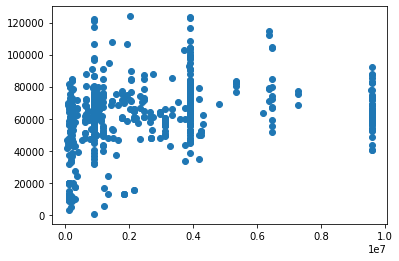

In [60]:
plt.scatter(df2['valor_suelo_num'], df2['price_square_meter']);

# Obtenemos información de la dirección

Como la base de precios tiene la latitud y longitug, obtenemos su dirección.

In [64]:
import geopy as gp

In [65]:
geolocator = gp.geocoders.Nominatim(user_agent='Marcos')

In [67]:
df[['address','lat','lon']].head(3)

,address,lat,lon
0,"Sinaloa 20 , Roma Sur",19.421317,-99.164182
1,Tonala,19.421029,-99.163541
2,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",19.407814,-99.161872


Ejemplo de uso

In [68]:
Latitude = '19.4193053'
Longitude = '-99.1538106'  
location = geolocator.reverse(Latitude+","+Longitude)
location.raw

{'place_id': 266399818,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 866462197,
 'lat': '19.419325785040904',
 'lon': '-99.15410034201929',
 'display_name': 'Avenida Cuauhtémoc, Colonia Doctores, Cuauhtémoc, Ciudad de México, 06720, México',
 'address': {'road': 'Avenida Cuauhtémoc',
  'neighbourhood': 'Colonia Doctores',
  'state': 'Ciudad de México',
  'ISO3166-2-lvl4': 'MX-CMX',
  'postcode': '06720',
  'country': 'México',
  'country_code': 'mx'},
 'boundingbox': ['19.4185725', '19.4197309', '-99.1541536', '-99.1540717']}

In [69]:
%%time
sam = {}
k = 0
for i in range(df.shape[0]):
    k = k+1
    lat = str(df['lat'][i])
    lon = str(df['lon'][i])
    location = geolocator.reverse(lat+','+lon)
    sam[i] = []
    sam[i].append(location.raw)
    # Barra de progreso
    sys.stdout.write('\r')
    sys.stdout.write("Iteration: {0}\tTotal: {1}".format(k,df.shape[0]))
    sys.stdout.flush()

Iteration: 981	Total: 981CPU times: user 8.58 s, sys: 1.42 s, total: 10 s
Wall time: 8min 10s


In [70]:
df['colonia'] = None
df['calle'] = None

In [72]:
for i in range(df.shape[0]):
    try:
        df.loc[i,'colonia'] = sam[i][0]['address']['neighbourhood']
    except:
        df.loc[i,'colonia'] = None

In [73]:
for i in range(df.shape[0]):
    try:
        df.loc[i,'calle'] = sam[i][0]['address']['road']
    except:
        df.loc[i,'calle'] = None

In [74]:
df[['address','lat','lon','colonia','calle']].head(3)

,address,lat,lon,colonia,calle
0,"Sinaloa 20 , Roma Sur",19.421317,-99.164182,Colonia Roma Norte,Calle Sinaloa
1,Tonala,19.421029,-99.163541,Colonia Roma Norte,Avenida Insurgentes Sur
2,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",19.407814,-99.161872,Colonia Roma Sur,Calle Tepeji


## Guardamos el diccionario y el Dataframe

In [76]:
import os
os.chdir('../Functions')
from utils import *

In [78]:
Utilerias.save_load_objects('../DD360/data/sam_dict',sam,'save')

In [81]:
df.to_csv('../DD360/data/reto_precios_cat_lat_lon.csv')